In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import ipywidgets as widgets
from IPython.display import clear_output

In [2]:
plt.rcParams["figure.figsize"] = (10, 10)
plt.rcParams["font.size"] = 18

## Summary

The goal is to define a method that allows to "encode" the shape of a lattice built from differently resolved areas. The lattice array combines a set of specifications into a single array that is used to build the representation of the lattice in array form. This representation allows to have a fixed dimensional Numpy array as the underlying data type. As an example, this array is used to save the dimensions of all cells individually.  
Building on top of that, a visual representation of a 1+1D lattice is plotted.

## The array defining the lattice spacing: `lattice array`

This array defines the number of lattice cells that are of a certain width. These values are stored as the second dimension, where the length of the first dimension depends on the number of varying mesh sizes. The last element for every nested (2. dim) array is the width of the area of the mesh in units of its step size. For building the complete lattice, this array is embedded in an array of the length of the time dimension, so that each time step effectively has its own `lattice array`.

In [3]:
# example 1D lattice array
# width of areas in units of the corresponding cell width
cells_areas = [2, 1, 5]
# cell width for the areas
width_areas = [2, 6, 2]

# lattice array
l = [[w, c] for w, c in zip(width_areas, cells_areas)]
print(l)

[[2, 2], [6, 1], [2, 5]]


In this example there are 3 areas with different step sizes on a 1D lattice. For 1+1D each time step will have such an array `l`. Also the `cell_areas` and `width_areas` need to have an additional dimension with the length equal to the number of time steps.  

Sidenote:  
As we allow for a different number of mesh areas per time step, these arrays cannot be pure Numpy arrays. This shouldn't be an issue, because the data we are dealing with at this stage will always be small. However, when dealing with a large temporal dimension, the outermost dimension could be implemented as a Numpy array with `dtype=object`. This theoretically should improve memory load for very large `time_steps`.
```
a = np.empty(time_steps, dtype=object)
a.fill(list())
```

In [4]:
# example 1+1D lattice array
# number of time steps: 4+2+4 = 10
time_steps = 10
# for each time step:
# width of areas in units of the corresponding cell width
cells_areas = [[20,],]*2 + [[10, 2, 6],]*4 + [[4,],]*2 + [[5, 10],]*2
# cell width for the areas
width_areas = [[1,],]*2 + [[1, 2, 1],]*4 + [[5,],]*2 + [[2, 1],]*2

# lattice array
l = list()
for i in range(time_steps):
    l.append([[w, c] for w, c in zip(width_areas[i], cells_areas[i])])

print(f"{cells_areas=}")
print(f"{width_areas=}")
display(l[::-1])

cells_areas=[[20], [20], [10, 2, 6], [10, 2, 6], [10, 2, 6], [10, 2, 6], [4], [4], [5, 10], [5, 10]]
width_areas=[[1], [1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [5], [5], [2, 1], [2, 1]]


[[[2, 5], [1, 10]],
 [[2, 5], [1, 10]],
 [[5, 4]],
 [[5, 4]],
 [[1, 10], [2, 2], [1, 6]],
 [[1, 10], [2, 2], [1, 6]],
 [[1, 10], [2, 2], [1, 6]],
 [[1, 10], [2, 2], [1, 6]],
 [[1, 20]],
 [[1, 20]]]

Here `l` is shown inverted, which will be the preferred representation where time increases upwards and space to the right (when looking at the 1+1D lattice on a 2D image).  
The `lattice array` is used to build a representation of the lattice in array form where each element now contains the dimensions of the cell it represents. As the lattice size shall take large numbers, this array is most effectively saved as a Numpy array. This requires that all elements of all dimensions have the same shape. So the array will always contain as many elements as the finest mesh resolution at any time step.
Finding the finest mesh for a cubic lattice is easy, as all space dimensions should have the same size.

In [5]:
# find the finest mesh:
fine_mesh = 0
for areas in l[0]:
    fine_mesh += areas[0]*areas[-1]
print(fine_mesh, end=", ")

fine_mesh = 0
for areas in l[4]:
    fine_mesh += areas[0]*areas[-1]
print(fine_mesh)

20, 20


When building the lattice representation, cells that are larger than the finest mesh size shall cover their subsequent cells, in the sense that those cells will have zero dimension. Here it comes into play, that the smallest spatial step must be 1 which is easily achieved by rescaling larger steps.

In [6]:
# for now set time step to 1
dt = 1
# for 1+1D, innermost dim = 2
full_lattice = np.empty((time_steps, fine_mesh, 2), dtype=np.int64)
# using l as the lattice array
for i in range(time_steps):
    mesh = list()
    for areas in l[i]:
        # if on coarser grid, insert 0 for subsequent sites
        app = [[dt,areas[0]],] + [[dt,0],]*(areas[0]-1)
        mesh += app*areas[-1]
    full_lattice[i] = np.array(mesh)

print("time step lattice")
for i in range(time_steps-1, -1, -1):
    for j in range(fine_mesh):
        print(full_lattice[i,j,0], end=", ")
    print("\n")
    
print("-"*90)
print("space step lattice")
for i in range(time_steps-1, -1, -1):
    for j in range(fine_mesh):
        print(full_lattice[i,j,1], end=", ")
    print("\n")

time step lattice
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

------------------------------------------------------------------------------------------
space step lattice
2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 

5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 5, 0, 0, 0, 0, 

1, 1

Here we have sneaked in how to include the width of the time step `dt` in the lattice array. In general the procedure is the same for any additional dimension, time like or space like, by just including more elements in the innermost arrays of the lattice array `l`. Following conventions, the index 0 shall be reserved for the time component (contrary to the example above, because there we only have one spatial dimension).  
Reformulating the initial conditions for the lattice array above, while dealing with the time step explicitly will have the form shown below and gives the same result as previously. For now we are still limited to a uniform grid in the temporal direction. It should be no surprise, that changing the stepping of a single dimension, requires to introduce an area for all dimensions, even if the other dimensions stepping does not change. In the example below, the time step is fixed to 1, but still `dt_areas` is split up into the same areas defined in `cell_areas`.

In [7]:
# example 1+1D lattice array with explicit time step
# number of time steps: 4+2+4 = 10
time_steps = 10
# for each time step:
# define an array with as many elements as areas of different meshing
# width of areas in units of the corresponding spatial cell width
cells_areas = [[20,],]*2 + [[10, 2, 6],]*4 + [[4,],]*2 + [[5, 10],]*2
# spatial cell width for the areas
width_areas = [[1,],]*2 + [[1, 2, 1],]*4 + [[5,],]*2 + [[2, 1],]*2
# temporal cell width for the areas
dt_areas = [[1,],]*2 + [[1, 1, 1],]*4 + [[1,],]*2 + [[1, 1],]*2

l = list()
for i in range(time_steps):
    l.append([[t, w, c] for t, w, c in zip(dt_areas[i], width_areas[i], cells_areas[i])])

print(f"{cells_areas=}")
print(f"{width_areas=}")
print(f"{dt_areas=}")
print("\nlattice_array=")
display(l[::-1])

# from here on, the spatial index for `areas` is 1 not 0,
# when comparing to the previous example
# the width of the area is still on index -1

# find the finest spatial mesh:
fine_mesh = 0
for areas in l[0]:
    fine_mesh += areas[1]*areas[-1]
print(f"{fine_mesh=}")
# finest timelike mesh will always be the number of time steps

# for 1+1D, innermost dim = 2
full_lattice = np.empty((time_steps, fine_mesh, 2), dtype=np.int64)

# using l as the lattice array
for i in range(time_steps):
    mesh = list()
    for areas in l[i]:
        # if on coarser grid, insert 0 for subsequent sites
        app = [[areas[0], areas[1]],] + [[areas[0], 0],]*(areas[1]-1)
        mesh += app*areas[-1]
    full_lattice[i] = np.array(mesh)

print("-"*90)
print("time step lattice")
for i in range(time_steps-1, -1, -1):
    for j in range(fine_mesh):
        print(full_lattice[i,j,0], end=", ")
    print("\n")
    
print("-"*90)
print("space step lattice")
for i in range(time_steps-1, -1, -1):
    for j in range(fine_mesh):
        print(full_lattice[i,j,1], end=", ")
    print("\n")
    
# save pointer for later use
full_lattice_fix_dt = full_lattice

cells_areas=[[20], [20], [10, 2, 6], [10, 2, 6], [10, 2, 6], [10, 2, 6], [4], [4], [5, 10], [5, 10]]
width_areas=[[1], [1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [5], [5], [2, 1], [2, 1]]
dt_areas=[[1], [1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1], [1], [1, 1], [1, 1]]

lattice_array=


[[[1, 2, 5], [1, 1, 10]],
 [[1, 2, 5], [1, 1, 10]],
 [[1, 5, 4]],
 [[1, 5, 4]],
 [[1, 1, 10], [1, 2, 2], [1, 1, 6]],
 [[1, 1, 10], [1, 2, 2], [1, 1, 6]],
 [[1, 1, 10], [1, 2, 2], [1, 1, 6]],
 [[1, 1, 10], [1, 2, 2], [1, 1, 6]],
 [[1, 1, 20]],
 [[1, 1, 20]]]

fine_mesh=20
------------------------------------------------------------------------------------------
time step lattice
1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

------------------------------------------------------------------------------------------
space step lattice
2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

5, 0, 0, 0, 0, 5, 0, 0, 

Allowing for variable time steps requires more care when building the `full_lattice`. A single loop over all time slices is not enough. The solution below iterates one additional time over `full_lattice`, after all spatial cell sizes are set and fixes the time stepping by setting the dt of (timelike) subsequent cells to 0, if dt > 1 for a cell in the current time slice.

In [8]:
# example 1+1D lattice array with variable time step
# number of time steps: 4+2+4 = 10
time_steps = 10
# for each time step:
# define an array with as many elements as areas of different meshing
# width of areas in units of the corresponding spatial cell width
cells_areas = [[20,],]*2 + [[10, 2, 6],]*4 + [[4,],]*2 + [[5, 10],]*2
# spatial cell width for the areas
width_areas = [[1,],]*2 + [[1, 2, 1],]*4 + [[5,],]*2 + [[2, 1],]*2
# temporal cell width for the areas
dt_areas = [[1,],]*2 + [[1, 2, 1],]*4 + [[1,],]*2 + [[2, 1],]*2

l = list()
for i in range(time_steps):
    l.append([[t, w, c] for t, w, c in zip(dt_areas[i], width_areas[i], cells_areas[i])])

print(f"{cells_areas=}")
print(f"{width_areas=}")
print(f"{dt_areas=}")
print("\nlattice_array=")
display(l[::-1])

# find the finest spatial mesh:
fine_mesh = 0
for areas in l[0]:
    fine_mesh += areas[1]*areas[-1]
print(f"{fine_mesh=}")
# finest timelike mesh will always be the number of time steps

# for 1+1D, innermost dim = 2
full_lattice = np.empty((time_steps, fine_mesh, 2), dtype=np.int64)

# using l as the lattice array
for i in range(time_steps):
    mesh = list()
    for areas in l[i]:
        # if on coarser grid, insert 0 for subsequent sites
        app = [[areas[0], areas[1]],] + [[areas[0], 0],]*(areas[1]-1)
        mesh += app*areas[-1]
    full_lattice[i] = np.array(mesh)

# set subsequent time dims for cells with dt>1 to zero
# just like for coarser spatial stepping
# use numpy functions for the possible large full_lattice
for i, lt in enumerate(full_lattice):
    max_dt = np.max(lt[:,0])
    for t in range(1, max_dt):
        full_lattice[i+t][lt[:,0]>t,0] = 0
    
print("-"*90)
print("time step lattice")
for i in range(time_steps-1, -1, -1):
    for j in range(fine_mesh):
        print(full_lattice[i,j,0], end=", ")
    print("\n")
    
print("-"*90)
print("space step lattice")
for i in range(time_steps-1, -1, -1):
    for j in range(fine_mesh):
        print(full_lattice[i,j,1], end=", ")
    print("\n")
    
# save pointer for later use
full_lattice_var_dt = full_lattice

cells_areas=[[20], [20], [10, 2, 6], [10, 2, 6], [10, 2, 6], [10, 2, 6], [4], [4], [5, 10], [5, 10]]
width_areas=[[1], [1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [5], [5], [2, 1], [2, 1]]
dt_areas=[[1], [1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1, 2, 1], [1], [1], [2, 1], [2, 1]]

lattice_array=


[[[2, 2, 5], [1, 1, 10]],
 [[2, 2, 5], [1, 1, 10]],
 [[1, 5, 4]],
 [[1, 5, 4]],
 [[1, 1, 10], [2, 2, 2], [1, 1, 6]],
 [[1, 1, 10], [2, 2, 2], [1, 1, 6]],
 [[1, 1, 10], [2, 2, 2], [1, 1, 6]],
 [[1, 1, 10], [2, 2, 2], [1, 1, 6]],
 [[1, 1, 20]],
 [[1, 1, 20]]]

fine_mesh=20
------------------------------------------------------------------------------------------
time step lattice
0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

------------------------------------------------------------------------------------------
space step lattice
2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

2, 0, 2, 0, 2, 0, 2, 0, 2, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 

5, 0, 0, 0, 0, 5, 0, 0, 

Before looking into visualizing the lattice we provide a function for later use of the methods implemented above. We also change the data type of the internal `lattice_array`(=`l`) to a Numpy array, as noted previously.

In [9]:
def generate_full_lattice_1_1D(cells_areas, width_areas, dt_areas):
    """Generate a Numpy array with the given cell layout.

    Args:
        cells_areas:
            Nested 2D Python list with width of each area
            in units of the stepping for that area.
        width_areas:
            Nested 2D Python list with spatial stepping
            for each area.
        dt_areas:
            Nested 2D Python list with temporal stepping
            for each erea.

    All arguments must share the same size for the outermost
    list and all sublists with the same position in their list
    must share the same size as well.

    Returns:
        Multidimensional Numpy array representation of the
        lattice with `shape = (Nt, Ns, 2)`. Nt: number of
        time slices, Ns: number of spatial cells, both given
        for the finest resolution at any given time slice.
        First dim is time, second dim is space and third dim
        is [dt, ds].
    """

    # find number of time steps Nt
    # take max so loop in next line raises error for wrong arguments
    time_steps = max(len(cells_areas), len(width_areas), len(dt_areas))

    l = np.empty(time_steps, dtype=object)
    for i in range(time_steps):
        l[i] = [[t, w, c] for t, w, c in zip(dt_areas[i], width_areas[i], cells_areas[i])]

    # find the finest spatial mesh:
    fine_mesh = 0
    for areas in l[0]:
        fine_mesh += areas[1] * areas[-1]

    # for 1+1D, innermost dim = 2
    full_lattice = np.empty((time_steps, fine_mesh, 2), dtype=np.int64)

    # using l as the lattice array
    
    # slow python list() version
#     for i in range(time_steps):
#         mesh = list()
#         for areas in l[i]:
#             # if on coarser grid, insert 0 for subsequent sites
#             app = [[areas[0], areas[1]],] + [[areas[0], 0], ] * (areas[1] - 1)
#             mesh += app * areas[-1]
#         full_lattice[i] = np.array(mesh)
    
    mesh = np.empty((fine_mesh, 2))
    for i in range(time_steps):
        start = 0
        for areas in l[i]:
            # set time step for all elements
            mesh[start : start+areas[-1]*areas[1]] = [areas[0], 0]
            # set correct spatial step with proper stepping through mesh
            mesh[start : start+areas[-1]*areas[1] : areas[1]] = [areas[0], areas[1]]
            start += areas[-1]*areas[1]
        full_lattice[i] = mesh

    # set subsequent time dims for cells with dt>1 to zero
    # just like for coarser spatial stepping
    for i, lt in enumerate(full_lattice):
        max_dt = np.max(lt[:, 0])
        for t in range(1, max_dt):
            full_lattice[i + t][lt[:, 0] > t, 0] = 0

    return full_lattice

## Plotting the 1+1D lattice

The method and code presented in this section closely follow existing implementations of Markus Leuthner. Small adjustments were necessary to deal with the `lattice array` from the previous section.

In [10]:
def plot_mesh_1_1D(field, lattice):
    """Color a `lattice` with values from `field`.

    Args:
        field: Numpy array with field values to plot.
        lattice:
            Numpy array with lattice spacings for each site.
            Takes return value of `generate_full_lattice_1_1D`.

    All args have require `shape = (Nt, Ns, 2)`. Nt: number of
    time slices, Ns: number of spatial cells, both given for
    the finest resolution at any given time slice.
    
    Returns:
        Tuple of `(fig, ax)`, where `fig` is the generated
        Matplotlib figure and `ax` the axes with the plot.
    """

    fig, ax = plt.subplots()
    ax.set_aspect("equal")
    # ax.axes.xaxis.set_visible(False)
    # ax.axes.yaxis.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    fig.patch.set_visible(False)
    # ax.set_frame_on(False)
    # this fixes missing lower and right boundary
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    duration = field.shape[0]
    length = field.shape[1]

    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$t\rightarrow$")

    # TODO:
    # change to addition to existing limits, to allow for iterative
    # application of this function on existing figures
    # ax.set_xlim(0, ax.get_xlims[-1] + np.max(np.sum(lattice[:, :, 1], 1)))
    
    # find limits based on fully varying lattice dimensions
    ax.set_xlim(0, np.max(np.sum(lattice[:, :, 1], 1)))
    ax.set_ylim(0, np.max(np.sum(lattice[:, :, 0], 0)))

    for t in range(duration):
        for x in range(length):

            value_positive = max(0, min(1, field[t, x]))
            value_negative = -1 * max(-1, min(0, field[t, x]))

            color = (
                1 - value_negative,
                1 - value_positive - value_negative,
                1 - value_positive,
            )  # rgb
            ax.add_patch(
                patches.Rectangle(
                    (np.sum(lattice[t, :x, 1]), np.sum(lattice[:t, x, 0])),
                    lattice[t, x, 1],
                    lattice[t, x, 0],
                    linewidth=1,
                    edgecolor="gray",
                    facecolor=color,
                )
            )

    return fig, ax

The generated images show a lattice in gray color that is sized according to the lattice specifications (which are taken from the `lattice` parameter). Time increases upwards and space to the right. The cells are filled according to the values of the `field` parameter. Red colors indicate positive field values and blue colors negative. A higher saturation equals larger values. The plotted range for the field values is limited to $[-1,1]$ which is sufficient for a sensible initial configuration and "brave" evolution. Nonetheless, examining fully saturated values might be necessary, if the contrast becomes to large (e.g. alternating/checkerboard patterns).

In [11]:
# plot 1+1D with fixed time step
a = np.zeros((time_steps, fine_mesh))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(time_steps, fine_mesh)
_, _ = plot_mesh_1_1D(fill, full_lattice_fix_dt)

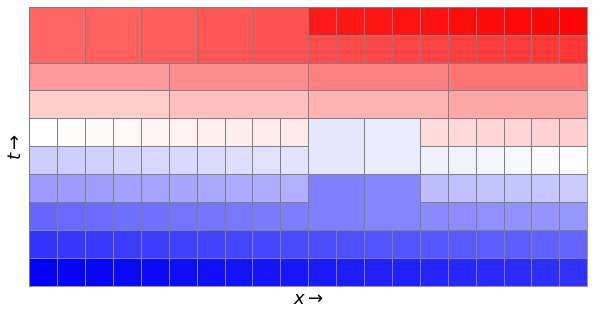

In [12]:
# plot 1+1D with variable time step
a = np.zeros((time_steps, fine_mesh))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(time_steps, fine_mesh)
_, _ = plot_mesh_1_1D(fill, full_lattice_var_dt)

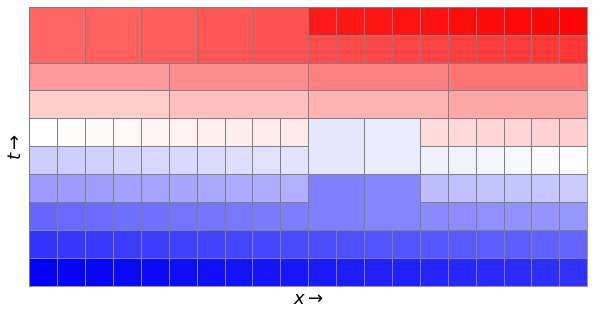

In [13]:
# plot same as above, but using generate_full_lattice_1_1D function

# width of areas in units of the corresponding spatial cell width
cells_areas = [[20,],]*2 + [[10, 2, 6],]*4 + [[4,],]*2 + [[5, 10],]*2
# spatial cell width for the areas
width_areas = [[1,],]*2 + [[1, 2, 1],]*4 + [[5,],]*2 + [[2, 1],]*2
# temporal cell width for the areas
dt_areas = [[1,],]*2 + [[1, 2, 1],]*4 + [[1,],]*2 + [[2, 1],]*2

# now plot 1+1D with sample color data `a`
a = np.zeros((time_steps, fine_mesh))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(time_steps, fine_mesh)
_, _ = plot_mesh_1_1D(fill, generate_full_lattice_1_1D(cells_areas, width_areas,dt_areas))

In [14]:
# plot one co-moving fine mesh
time_steps = 18
cells_areas = [[4, 8],]*2
for t in range(1, 8):
    cells_areas.extend([[t, 4, 8-t],]*2)
cells_areas.extend([[8, 4],]*2)

width_areas = [[1, 2],]*2
for t in range(1, 8):
    width_areas.extend([[2, 1, 2],]*2)
width_areas.extend([[2,1],]*2)

# allow only squares
dt_areas = width_areas

a = np.zeros((time_steps, fine_mesh))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(time_steps, fine_mesh)
_, _ = plot_mesh_1_1D(fill, generate_full_lattice_1_1D(cells_areas, width_areas,dt_areas))

In [15]:
# plot two co-moving fine meshes, intersecting
time_steps = 18
cells_areas = [[4, 6, 4],]*2
for t in range(1, 3):
    cells_areas.extend([[t, 4, 6-2*t, 4, t],]*2)
cells_areas.extend([[3, 8, 3],]*2)
cells_areas.extend([[4, 4, 4],]*2)
cells_areas.extend([[3, 8, 3],]*2)
for t in range(2,0,-1):
    cells_areas.extend([[t, 4, 6-2*t, 4, t],]*2)
cells_areas.extend([[4, 6, 4],]*2)

width_areas = [[1, 2, 1],]*2
for t in range(1, 3):
    width_areas.extend([[2, 1, 2, 1, 2],]*2)
width_areas.extend([[2, 1, 2],]*6)
for t in range(1, 3):
    width_areas.extend([[2, 1, 2, 1, 2],]*2)
width_areas.extend([[1, 2, 1],]*2)

# allow only squares
dt_areas = width_areas

a = np.zeros((time_steps, fine_mesh))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(time_steps, fine_mesh)
_, _ = plot_mesh_1_1D(fill, generate_full_lattice_1_1D(cells_areas, width_areas,dt_areas))

This example shows that numpy arrays are equally suited as the arguments for `generate_full_lattice_1_1D` and should in theory be better suited for a large number of time steps.  
(Warning! This takes a while)

In [16]:
# plot one co-moving fine mesh
def very_fine_co_moving_mesh():
    coarse_factor = 2
    space_steps = 300
    fine_width = 30
    time_steps = space_steps - fine_width + coarse_factor
    cells_areas = np.empty(time_steps, dtype=object)
    
    width_areas = np.empty(time_steps, dtype=object)
    width_areas.fill([coarse_factor, 1, coarse_factor])

    for i in range(coarse_factor):
        cells_areas[i] = [fine_width, (space_steps - fine_width)//coarse_factor]
        width_areas[i] = [1, coarse_factor]

    for t in range(1, (time_steps - coarse_factor)//coarse_factor):
        for i in range(coarse_factor):
            cells_areas[coarse_factor*t + i] = [t, fine_width, (space_steps - fine_width)//coarse_factor-t]

    for i in range(-coarse_factor, 0):
        cells_areas[i] = [(space_steps - fine_width)//coarse_factor, fine_width]
        width_areas[i] = [coarse_factor, 1]
        
    # allow only squares
    dt_areas = width_areas

    a = np.zeros((time_steps, space_steps))
    fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
    fill = fill.reshape(time_steps, space_steps)
    _, _ = plot_mesh_1_1D(fill, generate_full_lattice_1_1D(cells_areas, width_areas, dt_areas))

# plot mesh button
b = widgets.Button(description='Plot Lattice', tooltip='Click me')
plot_out = widgets.Output()
def click_button(b):
    plot_out.clear_output()
    with plot_out:
        very_fine_co_moving_mesh()
        plt.show()
    
b.on_click(click_button)
display(b, plot_out)

Button(description='Plot Lattice', style=ButtonStyle(), tooltip='Click me')

Output()

### Some simple trials for how to deal with 3+1D plots

This section does not contribute to the overall message of this notebook.

In [17]:
# example 3D lattice array
# width of areas in units of the corresponding cell width
cells_areas = [2, 1, 5]
# cell width for the areas
width_areas = [[2, 6, 2], [2, 2, 6], [6, 2, 2]]

l = np.array(
    [
        [w[i] for w in width_areas] + [c,]
        for i, c in enumerate(cells_areas)
    ]
)
l

array([[2, 2, 6, 2],
       [6, 2, 2, 1],
       [2, 6, 2, 5]])

In [18]:
# 3d Plotting

def plot_mesh_3_1D(field, lattice, center):

    fig, ax = plt.subplots(subplot_kw={"label": "a0", "projection": "3d"})
    #     ax.set_aspect("equal")
    # ax.axes.xaxis.set_visible(False)
    # ax.axes.yaxis.set_visible(False)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    fig.patch.set_visible(False)
    # ax.set_frame_on(False)
    for spine in ax.spines.values():
        spine.set_edgecolor("gray")

    duration = field.shape[0]
    length = [
        field.shape[2],
    ] * field.shape[1]

    ax.set_xlabel(r"$x\rightarrow$")
    ax.set_ylabel(r"$y\rightarrow$")
    ax.set_zlabel(r"$z\rightarrow$")

    # find limits based on fully varying lattice dimensions
    #     ax.set_xlim(0, np.max(np.sum(lattice[:, :, 1], 1)))
    #     ax.set_ylim(0, np.max(np.sum(lattice[:, :, 0], 0)))

    #     for t in range(duration):
    t = 0
    for d, ds in enumerate(length):
        for x in range(ds):

            value_positive = max(0, min(1, field[t, d, x]))
            value_negative = -1 * max(-1, min(0, field[t, d, x]))

            color = (
                1 - value_negative,
                1 - value_positive - value_negative,
                1 - value_positive,
            )  # rgb
            #             ax.add_patch(
            #                 patches.Rectangle(
            #                     (np.sum(lattice[t, :x, 1]), np.sum(lattice[:t, x, 0])),
            #                     lattice[t, x, 1],
            #                     lattice[t, x, 0],
            #                     linewidth=1,
            #                     edgecolor="gray",
            #                     facecolor=color,
            #                 )
            #             )
            def midpoints(x):
                sl = ()
                for i in range(x.ndim):
                    x = (x[sl + np.index_exp[:-1]] + x[sl + np.index_exp[1:]]) / 2.0
                    sl += np.index_exp[:]
                return x

            # prepare some coordinates
            r, theta, z = np.mgrid[0:1:11j, 0:np.pi*2:25j, -0.5:0.5:11j]
            x = r*np.cos(theta)
            y = r*np.sin(theta)

            rc, thetac, zc = midpoints(r), midpoints(theta), midpoints(z)

            # define a wobbly torus about [0.7, *, 0]
            sphere = (rc - center)**2 + (zc + 0.2*np.cos(thetac*2))**2 < 0.2**2

            # and plot everything
            ax.voxels(
                x, y, z, sphere,
                edgecolor="gray",
                facecolor=color,
                alpha=0.5,
            )

    return fig, ax

In [19]:
a = np.zeros((10, 3, 20,))
fill = (np.arange(0, a.size) - a.size / 2) / (a.size / 2)
fill = fill.reshape(10, 3, 20)

l = np.ones((10, 3, 20, 2))

@widgets.interact(interact=0.7, continuous_update=False)
def plotplot(interact):
    _, _ = plot_mesh_3_1D(fill, l, interact)

interactive(children=(FloatSlider(value=0.7, description='interact', max=2.0999999999999996, min=-0.7), Output…